#  Stack Overflow part : 2/3

Utilisation de la librairie Nb Extend pour mettre le code au format PEP 8.

## Fonction importante pour le modelling :

In [1]:
# potentiellement à optimisé pour une meilleure visibilité :
def visu_yellow(data):

    # Load the text data
    Balise = data

    vectorizer = CountVectorizer()
    docs = vectorizer.fit_transform(Balise)
    features = vectorizer.get_feature_names_out()
    # plt.figure(figsize=(18,12)) # Erreur => utilisation de size
    visualizer = FreqDistVisualizer(
        features=features, orient='v', size=(1080, 720))
    visualizer.fit(docs)
    visualizer.show()

In [2]:
def print_score(model, y_test, y_pred):
    Visualisation_score[model] = {"Accuracy :", metrics.accuracy_score(y_test, y_pred),
                                  "Hamming loss :", metrics.hamming_loss(
                                      y_test, y_pred),
                                  "jaccard_score :", metrics.jaccard_score(
                                      y_test, y_pred),
                                  }
    return Visualisation_score

In [3]:
def UMAP_Corpus_Visualization (text, data) :

    corpus = text

    tfidf = TfidfVectorizer()
    docs = tfidf.fit_transform(corpus.data)
    labels = corpus.target

    # Visualizer
    umap = UMAPVisualizer()
    umap.fit(docs, labels)
    umap.show()

## Importation des données

Pour les besoins du notebook nous ne conservons que les titres, corps du texte et tags des document importés. 

In [4]:
import pandas as pd
import numpy as np
import IPython.display
import re

from contractions import CONTRACTION_MAP  # pour les verbes contractées
# source : https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

# Pour la visualisation graphique :
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# pour le modelling des mots :
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
import lxml
import html5lib
from bs4 import BeautifulSoup

# Pour la visualisation des tokens :
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

# Pour les scores :
from sklearn import metrics
from sklearn.metrics import accuracy_score, jaccard_score, hamming_loss

# Pour supprimer les warnings :
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Pré-visualisation avant traitement :

In [5]:
data = pd.read_csv("P5_exploration.csv")
data.head()

,Title,Body,Tags
0,Using A Parent Associative Foreach Loop That C...,<p>I have a form that outputs images and their...,<php><foreach><pdo><associative-array>
1,How to run sql script in mysql on Ubuntu?,<p>I am new to sql. I know I can run script wi...,<mysql><sql><script>
2,token verification failing using JWK/JWT for u...,<p>I am trying to verify an idToken using a pu...,<python><oauth-2.0><jwt><rsa><jwk>
3,"Should the ""opening work"" of a context manager...","<p>I found the <a href=""https://book.pythontip...",<python><contextmanager>
4,How to disable Github branch protection rule f...,<p>I have a git repository where some of the c...,<github>


## Pré-traitement

Pour chacune de nos opérations, nous allons utiliser la fonction %%time pour nous permettre de connaître le temps entre chaque opération.

En considérant le temps entre chaque opération, si l'opération est trop longue, il conviendra de faire un pickle pour le garder en mémoire.

### Suppression des balises Tags :

In [6]:
# Preprocess les tags
data["Tags"] = data["Tags"].str.lower() 
data["Tags"] = data["Tags"].replace({"><" : " "}, regex=True)
data["Tags"] = data["Tags"].replace({"<" : ""}, regex=True)
data["Tags"] = data["Tags"].replace({">" : ""}, regex=True)

### Création de la colonne corpus :

Nous commençons par créer une nouvelle variable associant le titre (Title) et le corps du texte (Body)

In [7]:
%%time
data['Corpus'] = data['Title'] + ' ' + data['Body']
# Certains algorithmes auront besoin d'une liste
corpus = data['Corpus'].to_list()
# Certains algorithmes auront besoin d'une liste
tags = data['Tags'].to_list()
display(data.head(5))

,Title,Body,Tags,Corpus
0,Using A Parent Associative Foreach Loop That C...,<p>I have a form that outputs images and their...,php foreach pdo associative-array,Using A Parent Associative Foreach Loop That C...
1,How to run sql script in mysql on Ubuntu?,<p>I am new to sql. I know I can run script wi...,mysql sql script,How to run sql script in mysql on Ubuntu? <p>I...
2,token verification failing using JWK/JWT for u...,<p>I am trying to verify an idToken using a pu...,python oauth-2.0 jwt rsa jwk,token verification failing using JWK/JWT for u...
3,"Should the ""opening work"" of a context manager...","<p>I found the <a href=""https://book.pythontip...",python contextmanager,"Should the ""opening work"" of a context manager..."
4,How to disable Github branch protection rule f...,<p>I have a git repository where some of the c...,github,How to disable Github branch protection rule f...


CPU times: user 84.7 ms, sys: 21.4 ms, total: 106 ms
Wall time: 105 ms


In [8]:
print("Visualisation pré-nettoyage du Corpus :")
print('')
display(data.Corpus[0])
print('')

Visualisation pré-nettoyage du Corpus :



"Using A Parent Associative Foreach Loop That Contains A Glob Function (to delete files) and a PDO Statement To Update A Database - PHP <p>I have a form that outputs images and their related titles and tags via a <code>while</code> loop, and at the bottom of this form I have the option to delete an image.</p>\n<p>Because the input elements inside the form produce an array of values, when deleting an image I need to run the PDO statements and PHP <code>glob</code> methods that delete the images from their folders inside a parent foreach loop.</p>\n<p>I cannot get this to work though. Without the foreach loop I'm getting the PHP <code>Array to string conversion</code> error, which I understand/expect. This error throws on the line <code>$stmt-&gt;bindParam(':image_id', $image_id);</code> in the second section of code below.</p>\n<p>I think I need to wrap the code from in-between the <code>// ---- START FOREACH ?</code> and <code>// ---- END FOREACH ?</code> comments in an associative for

### Nettoyage HTML via beautiful soup :

Nous allons maintenant nettoyer les données en rapport avec les balises HTML.

In [9]:
%%time

def clean_html(text_html):
    soup = BeautifulSoup(text_html, "html5lib")
    for element in soup.find_all("code"):
        # print(element)
        element.decompose()
    return soup.get_text().replace("\n", " ")


corpus_del_bal = [clean_html(text) for text in corpus]
data['Corpus'] = data['Corpus'].apply(lambda x : clean_html(x))

CPU times: user 1min 43s, sys: 246 ms, total: 1min 43s
Wall time: 1min 43s


In [10]:
print("Visualisation du nettoyage Beautiful Soup :")
print('')
display(corpus_del_bal[0])
print('')

Visualisation du nettoyage Beautiful Soup :



"Using A Parent Associative Foreach Loop That Contains A Glob Function (to delete files) and a PDO Statement To Update A Database - PHP I have a form that outputs images and their related titles and tags via a  loop, and at the bottom of this form I have the option to delete an image. Because the input elements inside the form produce an array of values, when deleting an image I need to run the PDO statements and PHP  methods that delete the images from their folders inside a parent foreach loop. I cannot get this to work though. Without the foreach loop I'm getting the PHP  error, which I understand/expect. This error throws on the line  in the second section of code below. I think I need to wrap the code from in-between the  and  comments in an associative foreach loop, but I can't work how to do this in terms of the key/value pairs? Any help would be really appreciated. Output onto page (the issue is in the block of code after this)  Deleting An Image  "

#### Visualisation Yellowbricks en token :

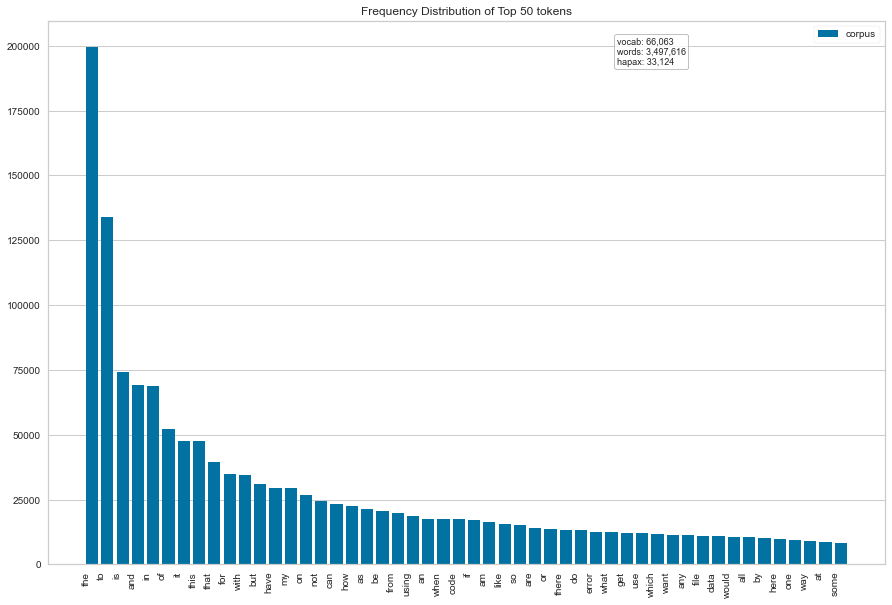

In [11]:
visu_yellow(corpus_del_bal)

On voit qu'il y a toujours des mots redondants qui ne servent à rien à l'analyse.

### Nettoyage du texte (Suppression des fins de lignes et des chiffres) :

ici, nous supprimons les fins de lignes et les chiffres.

In [12]:
%%time


def text_cleaning(text):
    text = re.sub('\w*\d\w*', '', text)  # supprimer tout les chiffres
    text = re.sub(r'\n', '', text)  # retirer les fins de lignes
    text = re.sub(r'\s+', ' ', text)  # retirer les fins de lignes de corpus
    # text = re.split("," , " ")
    return text


corpus_x = [text_cleaning(text) for text in corpus_del_bal]  # pour la liste
tags_x = [text_cleaning(text).strip() for text in tags]  # pour la liste
data['Corpus'] = data['Corpus'].apply(lambda x : text_cleaning(x))

CPU times: user 7.27 s, sys: 124 ms, total: 7.39 s
Wall time: 7.17 s


In [13]:
print('-'*45)
print("Visualisation du nettoyage texte sur le corpus :")
print('-'*45)
display(corpus_x[0])
print("")

print('-'*45)
print("Visualisation du nettoyage texte sur les tags :")
print('-'*45)
display(tags_x[0])
print("")

---------------------------------------------
Visualisation du nettoyage texte sur le corpus :
---------------------------------------------


"Using A Parent Associative Foreach Loop That Contains A Glob Function (to delete files) and a PDO Statement To Update A Database - PHP I have a form that outputs images and their related titles and tags via a loop, and at the bottom of this form I have the option to delete an image. Because the input elements inside the form produce an array of values, when deleting an image I need to run the PDO statements and PHP methods that delete the images from their folders inside a parent foreach loop. I cannot get this to work though. Without the foreach loop I'm getting the PHP error, which I understand/expect. This error throws on the line in the second section of code below. I think I need to wrap the code from in-between the and comments in an associative foreach loop, but I can't work how to do this in terms of the key/value pairs? Any help would be really appreciated. Output onto page (the issue is in the block of code after this) Deleting An Image "


---------------------------------------------
Visualisation du nettoyage texte sur les tags :
---------------------------------------------


'php foreach pdo associative-array'

#### Visualisation Yellowbricks en token :

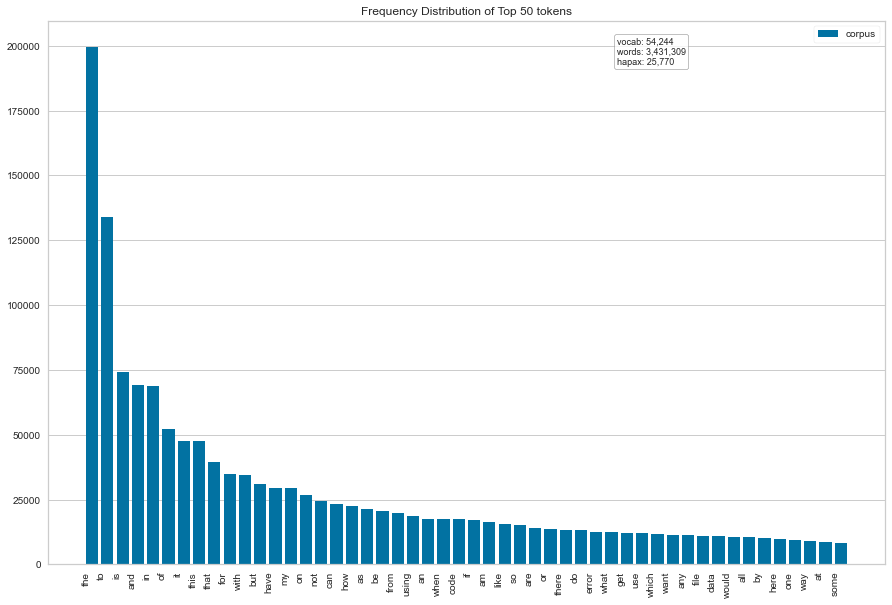

In [14]:
visu_yellow(corpus_x)

Le corpus pré-nettoyé reste actuellement inutilisable.

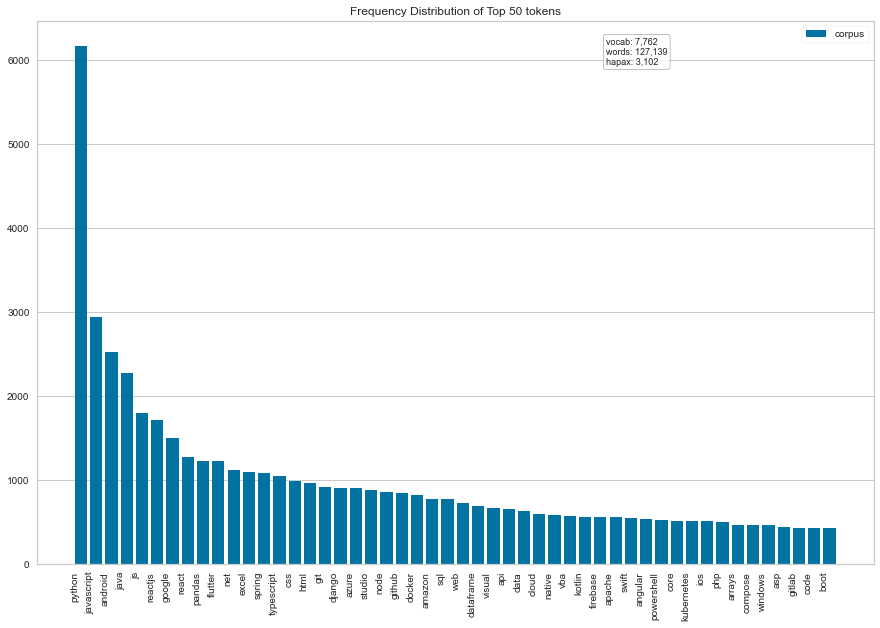

In [15]:
visu_yellow(tags_x)

Ici, on peut voir que les Tags sont bien représentés.

### Suppression des verbes contractées :

Suppression des formes contractés des verbes.

In [16]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
            if contraction_mapping.get(match)\
            else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [17]:
%%time
corpus_x = [expand_contractions(text) for text in corpus_del_bal]
tags_x = [expand_contractions(text).strip() for text in tags]
# data['Corpus'] = data['Corpus'].apply(lambda x : expand_contractions(x))

CPU times: user 27.7 s, sys: 150 ms, total: 27.8 s
Wall time: 27.6 s


In [18]:
print('-'*60)
print("Visualisation de la suppression des verbes contractés sur le corpus :")
print('-'*60)
display(corpus_x[0])
print("")

print('-'*60)
print("Visualisation de la suppression des verbes contractés sur les tags :")
print('-'*60)
display(tags_x[0])
print("")

------------------------------------------------------------
Visualisation de la suppression des verbes contractés sur le corpus :
------------------------------------------------------------


'Using A Parent Associative Foreach Loop That Contains A Glob Function (to delete files) and a PDO Statement To Update A Database - PHP I have a form that outputs images and their related titles and tags via a  loop, and at the bottom of this form I have the option to delete an image. Because the input elements inside the form produce an array of values, when deleting an image I need to run the PDO statements and PHP  methods that delete the images from their folders inside a parent foreach loop. I cannot get this to work though. Without the foreach loop I am getting the PHP  error, which I understand/expect. This error throws on the line  in the second section of code below. I think I need to wrap the code from in-between the  and  comments in an associative foreach loop, but I cannot work how to do this in terms of the key/value pairs? Any help would be really appreciated. Output onto page (the issue is in the block of code after this)  Deleting An Image  '


------------------------------------------------------------
Visualisation de la suppression des verbes contractés sur les tags :
------------------------------------------------------------


'php foreach pdo associative-array'

#### Visualisation Yellowbricks en token :

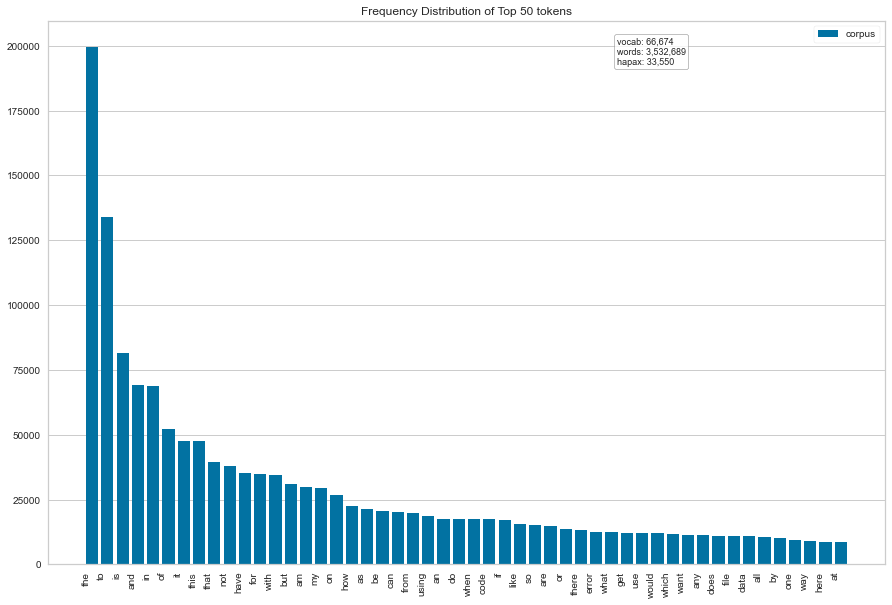

In [19]:
visu_yellow(corpus_x)

Peu de difference ici, vu que les mots contractées ne doivent pas être dans le top 50.

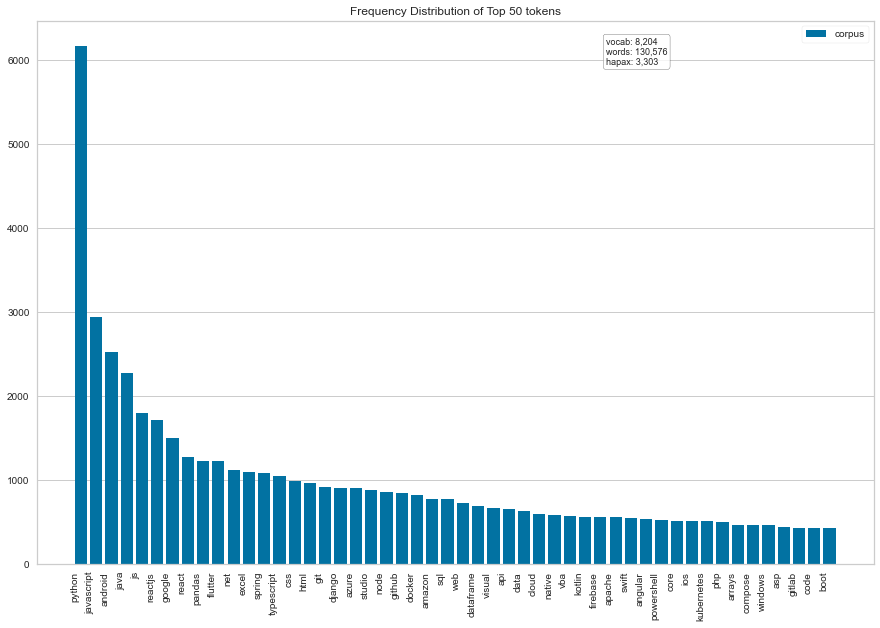

In [20]:
visu_yellow(tags_x)

Idem les tags étant déjà des termes spécifiques, pas de raison de retrouver une difference entre les 2.

### Tokenization + suppression des stopwords :

La tokenisation consiste essentielleent à diviser une phrase, paragraphe ou un document de texte en unités plus petites, entant que mots ou termes individuels. On appelle ces mots des tokens d'ou tokenisation.

Un stopword est un mot qui est tellement commun qu'il est inutile de l'indexer ou de l'utiliser dans une recherche.

In [21]:
import string  # permet d'avoir accés à toute les ponctuations.
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aurelien_gorguet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
def tokenize(text):

    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)

    try:
        res = word_tokenize(text, language='english')
    except TypeError:
        return text

    res = [token for token in res if token not in punctuation]
    res = [token for token in res if token not in stop_words]
   # res = [token for token in res if token not in letters]
    return res

In [23]:
%%time
corpus_token = [tokenize(text) for text in corpus_x]
tag_token = [tokenize(text) for text in tags_x]
# data['Corpus'] = data['Corpus'].apply(lambda x : tokenize(x))

CPU times: user 27.6 s, sys: 1.01 s, total: 28.6 s
Wall time: 28.9 s


In [24]:
print('-'*65)
print("Visualisation de la suppression de la tokennisation sur le corpus :")
print('-'*65)
display(corpus_token[0])
print("")

print('-'*65)
print("Visualisation de la suppression de la tokennisation sur les tags :")
print('-'*65)
display(tag_token[0])
print('')

-----------------------------------------------------------------
Visualisation de la suppression de la tokennisation sur le corpus :
-----------------------------------------------------------------


['Using',
 'A',
 'Parent',
 'Associative',
 'Foreach',
 'Loop',
 'That',
 'Contains',
 'A',
 'Glob',
 'Function',
 'delete',
 'files',
 'PDO',
 'Statement',
 'To',
 'Update',
 'A',
 'Database',
 'PHP',
 'I',
 'form',
 'outputs',
 'images',
 'related',
 'titles',
 'tags',
 'via',
 'loop',
 'bottom',
 'form',
 'I',
 'option',
 'delete',
 'image',
 'Because',
 'input',
 'elements',
 'inside',
 'form',
 'produce',
 'array',
 'values',
 'deleting',
 'image',
 'I',
 'need',
 'run',
 'PDO',
 'statements',
 'PHP',
 'methods',
 'delete',
 'images',
 'folders',
 'inside',
 'parent',
 'foreach',
 'loop',
 'I',
 'get',
 'work',
 'though',
 'Without',
 'foreach',
 'loop',
 'I',
 'getting',
 'PHP',
 'error',
 'I',
 'understand/expect',
 'This',
 'error',
 'throws',
 'line',
 'second',
 'section',
 'code',
 'I',
 'think',
 'I',
 'need',
 'wrap',
 'code',
 'in-between',
 'comments',
 'associative',
 'foreach',
 'loop',
 'I',
 'work',
 'terms',
 'key/value',
 'pairs',
 'Any',
 'help',
 'would',
 'reall


-----------------------------------------------------------------
Visualisation de la suppression de la tokennisation sur les tags :
-----------------------------------------------------------------


['php', 'foreach', 'pdo', 'associative-array']

###  POS tagging :

Parts of Speech (POS) Tagging. Parts of speech tagging simply refers to assigning parts of speech to individual words in a sentence, which means that, unlike phrase matching, which is performed at the sentence or multi-word level, parts of speech tagging is performed at the token level.

source : https://stackabuse.com/python-for-nlp-parts-of-speech-tagging-and-named-entity-recognition/

NN: noun, common, singular or mass

In [25]:
def filtering_nouns(text):

    res = nltk.pos_tag(text)

    res = [token[0] for token in res if token[1] == 'NN']# Rajouter adverbe etc etc

    return res

In [26]:
%%time
nn_corpus = [filtering_nouns(tokens) for tokens in corpus_token]

CPU times: user 1min 18s, sys: 431 ms, total: 1min 18s
Wall time: 1min 18s


In [27]:
print('-'*65)
print("Visualisation du POS Tagging sur le corpus :")
print('-'*65)
display(nn_corpus[0])
print("")

-----------------------------------------------------------------
Visualisation du POS Tagging sur le corpus :
-----------------------------------------------------------------


['delete',
 'loop',
 'form',
 'option',
 'image',
 'input',
 'form',
 'array',
 'image',
 'parent',
 'foreach',
 'loop',
 'foreach',
 'loop',
 'error',
 'error',
 'line',
 'section',
 'code',
 'code',
 'foreach',
 'loop',
 'help',
 'issue',
 'block',
 'code',
 'Image']

### Lemmatisation

La lemmatisation désigne un traitement lexical apporté à un texte en vue de son classement dans un index ou de son analyse. Ce traitement consiste à appliquer aux occurrences des lexèmes sujets à flexion un codage renvoyant à leur entrée lexicale commune, que l'on désigne sous le terme de lemme.

source : Wikipedia

In [28]:
from nltk.corpus import wordnet

In [29]:
def lemmatisation(text):

    # Init the Wordnet Lemmatizer
    lemmatizer = WordNetLemmatizer()

    res = [lemmatizer.lemmatize(word, wordnet.VERB) for word in text]
    res = [lemmatizer.lemmatize(word, wordnet.ADJ) for word in res]
    res = [lemmatizer.lemmatize(word, wordnet.NOUN) for word in res]
    res = [lemmatizer.lemmatize(word, wordnet.ADV) for word in res]
    return res

In [30]:
%%time
corpus_lem = [lemmatisation(tokens) for tokens in nn_corpus]
tags_lem = [lemmatisation(tokens) for tokens in tag_token]
# data['Corpus'] = data['Corpus'].apply(lambda x : lemmatisation(x))

tags_liste = []
for tokens in tags_lem:
    tokens = [token for token in tokens if len(token) > 1]
    tags_liste.append(tokens)

CPU times: user 6.61 s, sys: 35.5 ms, total: 6.64 s
Wall time: 6.66 s


In [31]:
print('-'*65)
print("Visualisation de la lemmatisation sur le corpus :")
print('-'*65)
display(corpus_lem[0])
print("")

print('-'*65)
print("Visualisation de la lemmatisation sur les Tags")
print('-'*65)
display(tags_lem[0])
print("")

-----------------------------------------------------------------
Visualisation de la lemmatisation sur le corpus :
-----------------------------------------------------------------


['delete',
 'loop',
 'form',
 'option',
 'image',
 'input',
 'form',
 'array',
 'image',
 'parent',
 'foreach',
 'loop',
 'foreach',
 'loop',
 'error',
 'error',
 'line',
 'section',
 'code',
 'code',
 'foreach',
 'loop',
 'help',
 'issue',
 'block',
 'code',
 'Image']


-----------------------------------------------------------------
Visualisation de la lemmatisation sur les Tags
-----------------------------------------------------------------


['php', 'foreach', 'pdo', 'associative-array']

# Features Engineering :

## Création des colonnes de preprocessing et création d'un nouveau DF :

In [32]:
# remettre sous forme de phrase et non sous forme de liste
corpus_df = [" ".join(text) for text in corpus_lem]
# On crée un dataframe
corpus_df = pd.DataFrame(corpus_df, columns=['corpus_preprocessing'])

In [33]:
corpus_df

,corpus_preprocessing
0,delete loop form option image input form array...
1,script mysql sql path way path path
2,verification authentication python decode func...
3,work context manager example manager file sugg...
4,branch protection rule configuration branch br...
...,...
31159,class compile time class compile time code sni...
31160,inline constraint function implementation look...
31161,classname javascript change class name li
31162,input change size shape tap shape user input e...


In [34]:
tags_df = [" ".join(tags) for tags in tags_liste]
tags_df = pd.DataFrame(tags_df, columns=['tags_preprocessing'])

In [35]:
tags_df

,tags_preprocessing
0,php foreach pdo associative-array
1,mysql sql script
2,python oauth-2.0 jwt rsa jwk
3,python contextmanager
4,github
...,...
31159,c++ c-preprocessor c++20 template-meta-program...
31160,typescript typescript-generics tsc generic-con...
31161,javascript html cs
31162,swift swiftui augmented-reality realitykit


In [36]:
df_final = pd.concat([corpus_df, tags_df], axis=1)

In [37]:
df_final['corpus_preprocessing'] = df_final['corpus_preprocessing'].apply(
    lambda x: x.split(' '))
df_final['tags_preprocessing'] = df_final['tags_preprocessing'].apply(
    lambda x: x.split(' '))

In [38]:
corpus_final = df_final['corpus_preprocessing'].to_list()
tags_final = df_final['tags_preprocessing'].to_list()
data_corpus_base = data['Corpus'].to_list()

In [39]:
df_visualisation = pd.concat([data['Corpus'],
                              data['Tags'],
                              df_final['corpus_preprocessing'],
                              df_final['tags_preprocessing']],
                             axis=1)

In [40]:
display(df_visualisation.head())
# Ici on voit bien qu'on a nos tags modifiés et non modifiés,.
# on pourra supprimer les balises via regex par la suite pour les tags

,Corpus,Tags,corpus_preprocessing,tags_preprocessing
0,Using A Parent Associative Foreach Loop That C...,php foreach pdo associative-array,"[delete, loop, form, option, image, input, for...","[php, foreach, pdo, associative-array]"
1,How to run sql script in mysql on Ubuntu? I am...,mysql sql script,"[script, mysql, sql, path, way, path, path]","[mysql, sql, script]"
2,token verification failing using JWK/JWT for u...,python oauth-2.0 jwt rsa jwk,"[verification, authentication, python, decode,...","[python, oauth-2.0, jwt, rsa, jwk]"
3,"Should the ""opening work"" of a context manager...",python contextmanager,"[work, context, manager, example, manager, fil...","[python, contextmanager]"
4,How to disable Github branch protection rule f...,github,"[branch, protection, rule, configuration, bran...",[github]


In [41]:
# Faire un CSV to dataframe pour éviter de tout relancer

Avant de calculer le bag of Word, le tf idf et le nmf, on va réduire le nombre de tags pour notre analyse.

## Comptage des Tags :

In [42]:
df_visualisation["Tags_count"] = df_visualisation["Tags"].apply(lambda x : len(x.split()))
df_visualisation.head()

,Corpus,Tags,corpus_preprocessing,tags_preprocessing,Tags_count
0,Using A Parent Associative Foreach Loop That C...,php foreach pdo associative-array,"[delete, loop, form, option, image, input, for...","[php, foreach, pdo, associative-array]",4
1,How to run sql script in mysql on Ubuntu? I am...,mysql sql script,"[script, mysql, sql, path, way, path, path]","[mysql, sql, script]",3
2,token verification failing using JWK/JWT for u...,python oauth-2.0 jwt rsa jwk,"[verification, authentication, python, decode,...","[python, oauth-2.0, jwt, rsa, jwk]",5
3,"Should the ""opening work"" of a context manager...",python contextmanager,"[work, context, manager, example, manager, fil...","[python, contextmanager]",2
4,How to disable Github branch protection rule f...,github,"[branch, protection, rule, configuration, bran...",[github],1


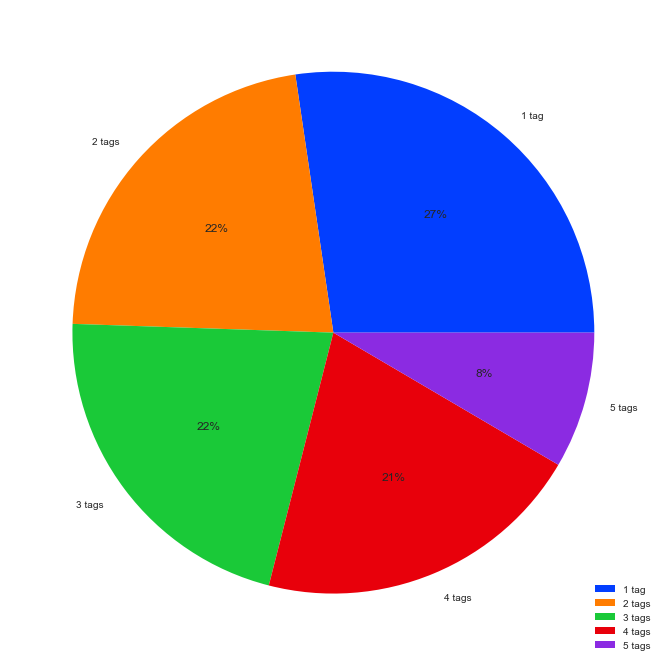

In [43]:
#define data
plt.figure(figsize=(12,12))
data = df_visualisation["Tags_count"].value_counts()
labels = ['1 tag', '2 tags', '3 tags', '4 tags', '5 tags']

#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.legend(labels)
plt.show()

In [44]:
print( "Le nombre de Tags dans une question est au nombre de : ", '\033[1m'+ str(round(df_visualisation["Tags_count"].mean(),2)) + '\033[0m')

Le nombre de Tags dans une question est au nombre de :  3.25


# Enregistrer le dataframe dans un CSV :

In [45]:
# df_visualisation.to_csv("P5_final.csv", index=False) # Cela permettra d'éviter d'attendre de relancer le notebook.

# Analyse non supervisée :

In [46]:
df_visualisation

,Corpus,Tags,corpus_preprocessing,tags_preprocessing,Tags_count
0,Using A Parent Associative Foreach Loop That C...,php foreach pdo associative-array,"[delete, loop, form, option, image, input, for...","[php, foreach, pdo, associative-array]",4
1,How to run sql script in mysql on Ubuntu? I am...,mysql sql script,"[script, mysql, sql, path, way, path, path]","[mysql, sql, script]",3
2,token verification failing using JWK/JWT for u...,python oauth-2.0 jwt rsa jwk,"[verification, authentication, python, decode,...","[python, oauth-2.0, jwt, rsa, jwk]",5
3,"Should the ""opening work"" of a context manager...",python contextmanager,"[work, context, manager, example, manager, fil...","[python, contextmanager]",2
4,How to disable Github branch protection rule f...,github,"[branch, protection, rule, configuration, bran...",[github],1
...,...,...,...,...,...
31159,C++ Separate different instances of a class at...,c++ c-preprocessor c++20 template-meta-program...,"[class, compile, time, class, compile, time, c...","[c++, c-preprocessor, c++20, template-meta-pro...",4
31160,Why does tsc inline generic constraint? I have...,typescript typescript-generics tsc generic-con...,"[inline, constraint, function, implementation,...","[typescript, typescript-generics, tsc, generic...",4
31161,changing the classname of the specific Li that...,javascript html css,"[classname, javascript, change, class, name, li]","[javascript, html, cs]",3
31162,User input to change size of shape that is gen...,swift swiftui augmented-reality realitykit,"[input, change, size, shape, tap, shape, user,...","[swift, swiftui, augmented-reality, realitykit]",4


## BOW :

### Pour les tags : 

In [47]:
from nltk.tokenize import word_tokenize

In [48]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_bow = vectorizer.fit_transform(df_visualisation['Tags'])

In [49]:
print("Nombres de questions :", tag_bow.shape[0])
print("Nombres de tags uniques :", tag_bow.shape[1])

Nombres de questions : 31164
Nombres de tags uniques : 11383


Visualisation des 10 premiers Tags :

In [50]:
tags_name = vectorizer.get_feature_names_out()
print("Visualisation des 10 premiers tags pour le BOW :", tags_name[:10])

Visualisation des 10 premiers tags pour le BOW : ['.class-file' '.d.ts' '.git-folder' '.htaccess' '.net' '.net-4.0'
 '.net-4.5' '.net-4.6.1' '.net-4.8' '.net-5']


In [51]:
frequence = tag_bow.sum(axis=0).A1 # Equivalent to ravel
tag_dict = dict(zip(tags, frequence))

In [52]:
liste = []
for key, value in tag_dict.items():
  liste.append([key, value]) 

In [53]:
tag_counting = pd.DataFrame(liste, columns=['Tags', 'Counts'])
tag_counting.head(10)

,Tags,Counts
0,php foreach pdo associative-array,2
1,mysql sql script,2
2,python oauth-2.0 jwt rsa jwk,1
3,python contextmanager,24
4,github,1
5,go go-modules,1
6,go struct,1
7,python pandas duplicates pandas-groupby,2
8,python list slice,12
9,tensorflow machine-learning keras computer-vis...,11


In [54]:
display(tag_counting.max())
display(tag_counting.min())

Tags      zsh zshrc zsh-completion
Counts                        5076
dtype: object

Tags      .net amazon-web-services oauth-2.0 amazon-cogn...
Counts                                                    1
dtype: object

Text(0, 0.5, 'Fréquence')

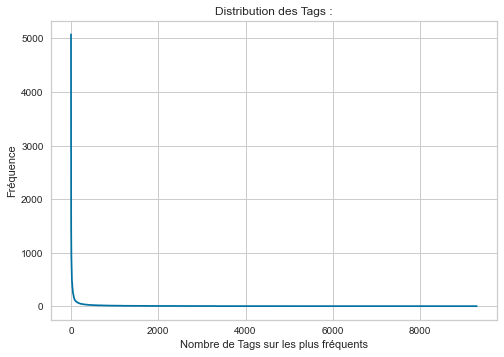

In [55]:
tag_counting_graph = tag_counting.sort_values(['Counts'], ascending=False)
plt.plot(tag_counting_graph['Counts'].values)
plt.grid(True)
plt.title("Distribution des Tags :")
plt.xlabel("Nombre de Tags sur les plus fréquents")
plt.ylabel("Fréquence")

Text(0, 0.5, 'Fréquence')

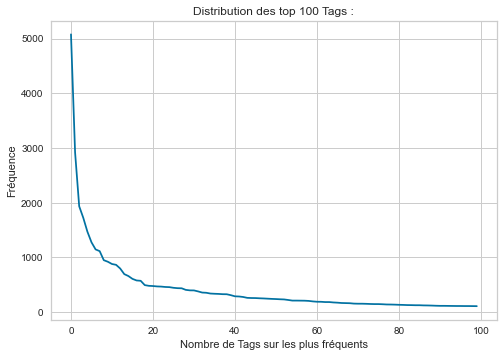

In [56]:
plt.plot(tag_counting_graph['Counts'][0:100].values)
plt.grid(True)
plt.title("Distribution des top 100 Tags :")
plt.xlabel("Nombre de Tags sur les plus fréquents")
plt.ylabel("Fréquence")

Text(0, 0.5, 'Fréquence')

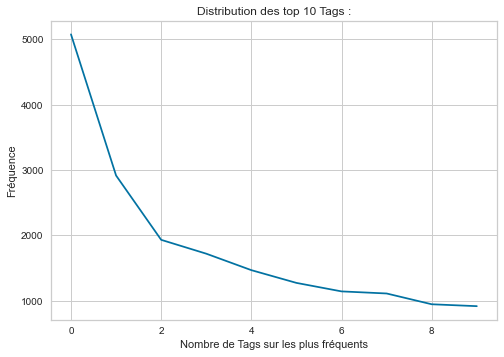

In [57]:
plt.plot(tag_counting_graph['Counts'][0:10].values)
plt.grid(True)
plt.title("Distribution des top 10 Tags :")
plt.xlabel("Nombre de Tags sur les plus fréquents")
plt.ylabel("Fréquence")

On peut voir qu'à partir de 8 on commence à avoir une fréquence inférieur à 1000, on aurait donc tendance à garder 1000 en fréquence.

Et 8 en tag number max

In [58]:
print("{} tags qui sont utilisés plus de 10 fois".format(tag_counting[tag_counting["Counts"]>10].shape[0]))
print("{} tags qui sont utilisés plus de 25 fois".format(tag_counting[tag_counting["Counts"]>25].shape[0]))
print("{} tags qui sont utilisés plus de 50 fois".format(tag_counting[tag_counting["Counts"]>50].shape[0]))
print("{} tags qui sont utilisés plus de 100 fois".format(tag_counting[tag_counting["Counts"]>100].shape[0]))
print("{} tags qui sont utilisés plus de 200 fois".format(tag_counting[tag_counting["Counts"]>200].shape[0]))
print("{} tags qui sont utilisés plus de 500 fois".format(tag_counting[tag_counting["Counts"]>500].shape[0]))

972 tags qui sont utilisés plus de 10 fois
400 tags qui sont utilisés plus de 25 fois
206 tags qui sont utilisés plus de 50 fois
103 tags qui sont utilisés plus de 100 fois
59 tags qui sont utilisés plus de 200 fois
18 tags qui sont utilisés plus de 500 fois


On peut voir confirmation que le top 206 tags sont utilisés plus de 50x, donc interessant à mettre en place.

In [59]:
"""df_visualisation['Corpus'] = df_visualisation['Corpus'].str.lower()
df_visualisation['Corpus'] = df_visualisation['Corpus'].apply(lambda x : tokenize(x))
df_visualisation['Corpus'] = df_visualisation['Corpus'].apply(lambda x : filtering_nouns(x))
df_visualisation['Corpus'] = df_visualisation['Corpus'].apply(lambda x : lemmatisation(x))"""

"df_visualisation['Corpus'] = df_visualisation['Corpus'].str.lower()\ndf_visualisation['Corpus'] = df_visualisation['Corpus'].apply(lambda x : tokenize(x))\ndf_visualisation['Corpus'] = df_visualisation['Corpus'].apply(lambda x : filtering_nouns(x))\ndf_visualisation['Corpus'] = df_visualisation['Corpus'].apply(lambda x : lemmatisation(x))"

In [60]:
df_visualisation["Corpus"] = df_visualisation["corpus_preprocessing"].apply(lambda x : " ".join(x))

In [61]:
df_visualisation

,Corpus,Tags,corpus_preprocessing,tags_preprocessing,Tags_count
0,delete loop form option image input form array...,php foreach pdo associative-array,"[delete, loop, form, option, image, input, for...","[php, foreach, pdo, associative-array]",4
1,script mysql sql path way path path,mysql sql script,"[script, mysql, sql, path, way, path, path]","[mysql, sql, script]",3
2,verification authentication python decode func...,python oauth-2.0 jwt rsa jwk,"[verification, authentication, python, decode,...","[python, oauth-2.0, jwt, rsa, jwk]",5
3,work context manager example manager file sugg...,python contextmanager,"[work, context, manager, example, manager, fil...","[python, contextmanager]",2
4,branch protection rule configuration branch br...,github,"[branch, protection, rule, configuration, bran...",[github],1
...,...,...,...,...,...
31159,class compile time class compile time code sni...,c++ c-preprocessor c++20 template-meta-program...,"[class, compile, time, class, compile, time, c...","[c++, c-preprocessor, c++20, template-meta-pro...",4
31160,inline constraint function implementation look...,typescript typescript-generics tsc generic-con...,"[inline, constraint, function, implementation,...","[typescript, typescript-generics, tsc, generic...",4
31161,classname javascript change class name li,javascript html css,"[classname, javascript, change, class, name, li]","[javascript, html, cs]",3
31162,input change size shape tap shape user input e...,swift swiftui augmented-reality realitykit,"[input, change, size, shape, tap, shape, user,...","[swift, swiftui, augmented-reality, realitykit]",4


In [62]:
def bag_of_words (texts) :
    data = texts
    cv = CountVectorizer(min_df = 200).fit(data)
    bow = cv.transform(data)
    
   # print ("Taille : ",  len (cv.vocabulary_))
   # print ("Contenu : ",  cv.vocabulary_) # too long
    
   # Nombre de lignes et de colonnes de la matrice via Bag Of Words :
   # print(bow.toarray().shape)
    
    data = pd.DataFrame.from_dict(cv.vocabulary_, orient='index',
                       columns=['Frequency'])
    data = data.sort_values(by=['Frequency'], ascending = False)
    data = data[data['Frequency']>200]
    
    data['percent'] = round((data['Frequency'])*100/ data['Frequency'].sum(),2)
    
    return(data, bow)

### Création d'un DataFrame de visualisation + une matrice :

In [63]:
%%time
data_bow,bow = bag_of_words(df_visualisation["Corpus"])

CPU times: user 880 ms, sys: 143 ms, total: 1.02 s
Wall time: 735 ms


In [64]:
print("Nombres de questions pour le BOW:", bow.shape[0])
print("Nombres de tags uniques pour le BOW :", bow.shape[1])

Nombres de questions pour le BOW: 31164
Nombres de tags uniques pour le BOW : 396


#### Visualisation : 

In [65]:
data_bow

,Frequency,percent
year,395,0.68
work,394,0.68
word,393,0.68
window,392,0.67
website,391,0.67
...,...,...
location,205,0.35
load,204,0.35
list,203,0.35
link,202,0.35


### Vectorisation :

In [66]:
%%time
cv = CountVectorizer(min_df = 200)
data_bow_2 = cv.fit_transform(df_visualisation["Corpus"])
data_bow_vec = pd.DataFrame(data_bow_2.toarray(), columns=cv.get_feature_names_out())
data_bow_vec.index = df_final.index

CPU times: user 399 ms, sys: 28.3 ms, total: 427 ms
Wall time: 448 ms


In [67]:
data_bow_vec

,access,account,action,add,address,advance,advice,algorithm,amount,android,...,version,video,view,way,web,website,window,word,work,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31159,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31160,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31162,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [68]:
%%time
score_Sparsicity_bow = data_bow_2.todense()
print("Sparsicity: ", '\033[1m'+ str((((score_Sparsicity_bow > 0).sum()/score_Sparsicity_bow.size)*100).round(2)) + '\033[0m' , "%")

Sparsicity:  2.29 %
CPU times: user 20.8 ms, sys: 27.3 ms, total: 48.1 ms
Wall time: 55.6 ms


Afficher la Sparsicity (sous forme de nombre ou de proportion) d'une matrice.

Par exemple, . 99% de  Sparsicity signifie que 99 % des valeurs sont nulles. De même, une Sparsicity de 0 signifie que la matrice est entièrement dense.

## TF-IDF :

La formule du tf-Idf est  : __poids = fréquence du terme * indicateur similarité__

__Pour extraire les informations on utilise :__

__NER (Named Entity Recognition) :__ reconnaître des personnes, endroits, entreprises, etc.

__Extraction de relations :__ essayer d'extraire des relations sémantiques entre différents termes du texte. Par exemple, des relations familiales ("Marie est l'enfant de Patrick") spatiales ("Le piano est devant la fenêtre"), etc. Ces informations peuvent ensuite être stockées dans une base de données relationnelles ou un graphe.

__Extraction d'événements :__ extraire des actions qui arrivent à nos entités. Par exemple "le cours de l'action X a augmenté de 5%" ou bien "le président à déclaré X dans son discours"

__POS Tagging (Part-of-Speech Tagging) :__ représente les méthodes qui récupèrent la nature grammatical des mots d’une phrase - nom, verbe, adjectif, etc. Ce sont des propriété qui peuvent servir de caractéristiques utile lors de la création de certains modèles

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [70]:
def Tfidf (texts) :
    data = texts
    tf = TfidfVectorizer(min_df = 200).fit(data) # on choisit de prendre que les mots avec 200 itérations
    idf = tf.transform(texts)
    
    #print ("Taille : ",  len (tf.vocabulary_))
    # print ("Contenu : ",  tf.vocabulary_) # too long
    
    # Nombre de lignes et de colonnes de la matrice via Bag Of Words :
    #print(idf.toarray().shape)
    
    data = pd.DataFrame.from_dict(tf.vocabulary_, orient='index',
                       columns=['Frequency'])
    data = data.sort_values(by=['Frequency'], ascending = False)
    data = data[data['Frequency']>200]
    
    data['percent'] = round((data['Frequency']*100)/ data['Frequency'].sum(),2)
    
    return(data,idf)

### Création d'un DataFrame de visualisation + une matrice :

In [71]:
%%time
Data_idf,idf = Tfidf(df_visualisation["Corpus"])

CPU times: user 711 ms, sys: 7.52 ms, total: 718 ms
Wall time: 723 ms


In [72]:
print("Nombres de questions pour le TF-IDF :", idf.shape[0])
print("Nombres de tags uniques pour le TF-IDF :", idf.shape[1])

Nombres de questions pour le TF-IDF : 31164
Nombres de tags uniques pour le TF-IDF : 396


#### Visualisation :

In [73]:
Data_idf

,Frequency,percent
year,395,0.68
work,394,0.68
word,393,0.68
window,392,0.67
website,391,0.67
...,...,...
location,205,0.35
load,204,0.35
list,203,0.35
link,202,0.35


### Vectorisation :

In [74]:
tfidf = TfidfTransformer()
data_tfidf = tfidf.fit_transform(bow)
data_tfidf_vec = pd.DataFrame(data_tfidf.toarray(), columns=cv.get_feature_names_out())
data_tfidf_vec.index = df_final.index
data_tfidf_vec.head()

,access,account,action,add,address,advance,advice,algorithm,amount,android,...,version,video,view,way,web,website,window,word,work,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.16853,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.232541,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0


In [75]:
%%time
score_Sparsicity_tfidf = data_tfidf.todense()
print("Sparsicity: ", '\033[1m'+ str((((score_Sparsicity_tfidf > 0).sum()/score_Sparsicity_tfidf.size)*100).round(2)) + '\033[0m' , "%")

Sparsicity:  2.29 %
CPU times: user 20.4 ms, sys: 26.6 ms, total: 47 ms
Wall time: 51.1 ms


On a donc 4.05% de données avec un 0 dans notre tf-idf.

## ACP :

In [76]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler # classe pour standardisation
from sklearn import preprocessing
from sklearn import decomposition
import matplotlib.pyplot as plt

Le code provient d'un cours d'OpenClassrooms.

In [77]:
%%time
vectorizer = TfidfVectorizer(min_df = 200)
X = vectorizer.fit_transform(df_visualisation["Corpus"])

CPU times: user 390 ms, sys: 5.43 ms, total: 395 ms
Wall time: 433 ms


In [78]:
from matplotlib.collections import LineCollection

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    """Display correlation circles, one for each factorial plane"""

    # For each factorial plane
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # Initialise the matplotlib figure
            fig, ax = plt.subplots(figsize=(10,10))

            # Determine the limits of the chart
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Add arrows
            # If there are more than 30 arrows, we do not display the triangle at the end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (see the doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # Display circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Define the limits of the chart
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Display grid lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlation Circle (PC{} and PC{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)
   
def display_scree_plot(pca):
    '''Display a scree plot for the pca'''

    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Scree plot")
    plt.show(block=False)

In [79]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [80]:
# constitution du dataset pour l'ACP
df_acp = pd.DataFrame(data = X.toarray(),  
                      columns = list(vectorizer.get_feature_names_out()))

n_comp = 200
scaler = StandardScaler()
pca = PCA(n_components=n_comp)

X = df_acp.values
features = df_acp.columns
X_scaled = scaler.fit_transform(X)
pca_components = pca.fit_transform(X_scaled)
pcs = pca.components_

In [81]:
%%time
PCA_decomposition = decomposition.PCA(n_components = 200)
PCA_decomposition.fit(X_scaled)

CPU times: user 12.8 s, sys: 5.25 s, total: 18 s
Wall time: 3.28 s


PCA(n_components=200)

In [82]:
print('\033[1m'+ 'Le pourcentage de variance expliqué pour 200 composantes est de :' + '\033[0m')
print('')
print((PCA_decomposition.explained_variance_ratio_)*100)
print('')
print(f"Le pourcentage de variance expliqué cumulé pour 200 composantes est de :", '\033[1m'+ str(round((PCA_decomposition.explained_variance_ratio_.sum())*100,2)) +'\033[0m', '%')

Le pourcentage de variance expliqué pour 200 composantes est de :

[0.690963   0.50965695 0.49555935 0.47207704 0.44168005 0.41838897
 0.40681733 0.39465698 0.3915285  0.37727875 0.36524566 0.362579
 0.3602401  0.35485681 0.34868673 0.3457375  0.3411778  0.33753099
 0.33437181 0.33146979 0.32947917 0.32895821 0.32706009 0.3249439
 0.32194417 0.31777427 0.31532601 0.31389064 0.31232529 0.31116153
 0.30917987 0.30764498 0.3060171  0.3052524  0.30268575 0.30221756
 0.30070039 0.29929657 0.29837396 0.29719465 0.29679434 0.29448982
 0.29354559 0.29343901 0.29262751 0.29195218 0.29101411 0.28958789
 0.28917354 0.28887469 0.2883765  0.28763243 0.28706368 0.28637424
 0.28603456 0.2854044  0.28396195 0.28359604 0.2829778  0.28245602
 0.28201763 0.28103197 0.28086476 0.28006081 0.27987393 0.27957509
 0.27841901 0.2779449  0.27784774 0.2775323  0.27666325 0.27610314
 0.2755538  0.27506422 0.27424904 0.27399191 0.27327553 0.27311487
 0.27250521 0.27239143 0.27156884 0.27126403 0.27112119 0.2705951

### Visualisation des dimensions :

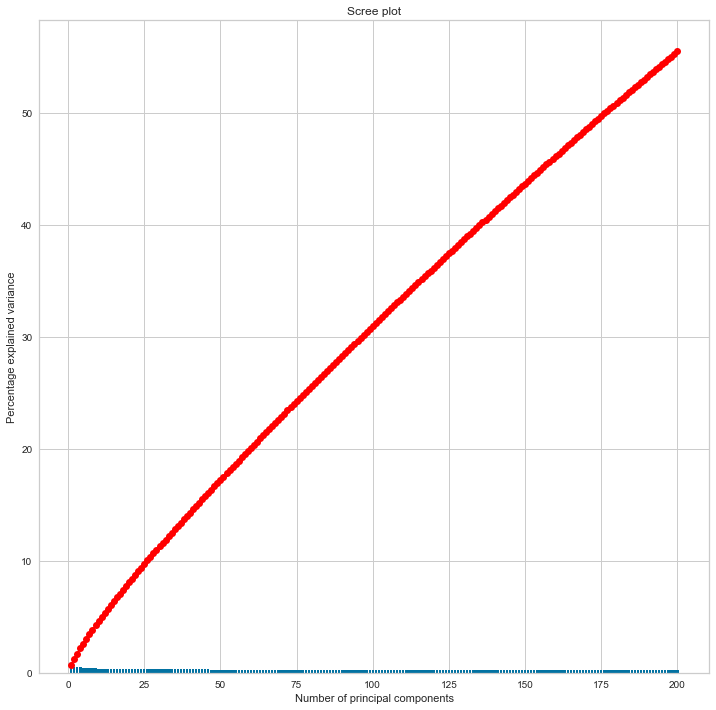

In [83]:
plt.figure(figsize=(12, 12))
display_scree_plot(pca)

On peut voir qu'au fur et à mesure cela réduit, mais que le pourcentage de variance expliquée est relativement faible..

### Cercle de corrélation :

<Figure size 1440x1440 with 0 Axes>

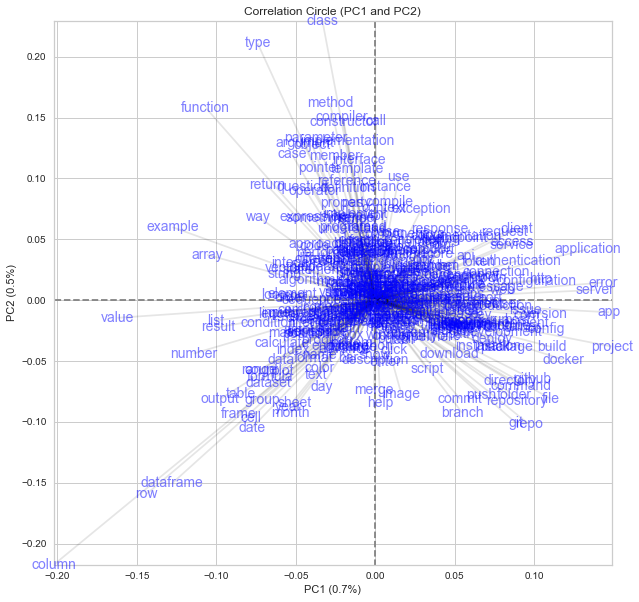

In [84]:
plt.figure(figsize=(20, 20))
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

### Vectorisation de la PC1 et PC2 :

<Figure size 2160x2160 with 0 Axes>

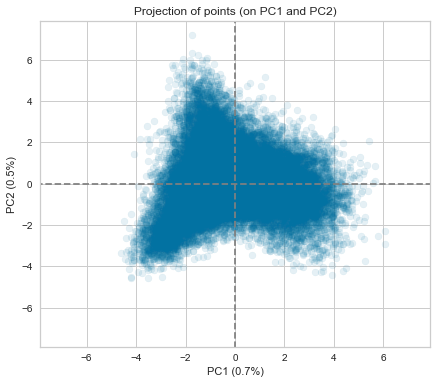

In [85]:
X_projected = pca.transform(X_scaled) 

plt.figure(figsize=(30, 30))
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], alpha = 0.1)
plt.show()

On peut voir ici que la PCA n'est pas pertinente, de ce fait on ne retiendra pas l'acp.

## LDA :

Hypothése de la LDA à confirmer :

    - Chaque document du corpus est un ensemble de mots sans ordre (bag-of-words)
    
    - Chaque document n'aborde un certain nombre de thèmes dans différentes proportions qui lui sont propres p(θm)

    - Chaque mot possède une distribution associée à chaque thème p(ϕk)
    
    - Zn représente le thème du mot Wn


In [86]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

### lda opti pour le BOW :

In [87]:
"""def lda_opti (texts) :

    score = []
    perplexity = []
    N = [5, 6, 7, 8, 9, 10, 11, 12, 15, 18, 20, 30]
    
    for n_comp in N :
        
        lda_model = LatentDirichletAllocation(random_state=0, n_components= n_comp, verbose = 2) # no random
        lda_fit = lda_model.fit(texts)
        lda_output = lda_fit.transform(texts)
        lda_score =  lda_fit.score(texts)
        score.append(lda_score)
        #print("Le score de cohérence est de :", score)
        lda_perplexity =lda_fit.perplexity(texts)
        perplexity.append(lda_perplexity)
        #print("Le score de perplexité est de :", perplexity)

    return(score, perplexity)"""

'def lda_opti (texts) :\n\n    score = []\n    perplexity = []\n    N = [5, 6, 7, 8, 9, 10, 11, 12, 15, 18, 20, 30]\n    \n    for n_comp in N :\n        \n        lda_model = LatentDirichletAllocation(random_state=0, n_components= n_comp, verbose = 2) # no random\n        lda_fit = lda_model.fit(texts)\n        lda_output = lda_fit.transform(texts)\n        lda_score =  lda_fit.score(texts)\n        score.append(lda_score)\n        #print("Le score de cohérence est de :", score)\n        lda_perplexity =lda_fit.perplexity(texts)\n        perplexity.append(lda_perplexity)\n        #print("Le score de perplexité est de :", perplexity)\n\n    return(score, perplexity)'

In [88]:
"""def lda_opti (texts) :

    lda_model = LatentDirichletAllocation(random_state=0) # no random
    score = []
    perplexity = []
    
    # Hyperparameters :
    params = { 
        'n_components': [5, 6, 7, 8, 9, 10, 11, 12, 15, 18, 20, 30], # number of component
        'learning_decay': [0.75, 0.80, 0.85] # learning rate from online method
    }

    # GridSearchCV :
    lda_search = GridSearchCV(lda_model,
                              param_grid=params,
                              #n_jobs=-1,
                              cv=5,
                              verbose=2
                             )
    
    
    lda_fit = lda_search.fit(texts) # fit data
    lda_output = lda_fit.transform(texts) # tranform data
    lda_score =  lda_fit.score(texts)
    score.append(lda_score)
    lda_perplexity =lda_fit.perplexity(texts)
    perplexity.append(lda_perplexity)
    
    return(score, perplexity, lda_output)"""

# Une méthode plus rapide a été utilisée.

"def lda_opti (texts) :\n\n    lda_model = LatentDirichletAllocation(random_state=0) # no random\n    score = []\n    perplexity = []\n    \n    # Hyperparameters :\n    params = { \n        'n_components': [5, 6, 7, 8, 9, 10, 11, 12, 15, 18, 20, 30], # number of component\n        'learning_decay': [0.75, 0.80, 0.85] # learning rate from online method\n    }\n\n    # GridSearchCV :\n    lda_search = GridSearchCV(lda_model,\n                              param_grid=params,\n                              #n_jobs=-1,\n                              cv=5,\n                              verbose=2\n                             )\n    \n    \n    lda_fit = lda_search.fit(texts) # fit data\n    lda_output = lda_fit.transform(texts) # tranform data\n    lda_score =  lda_fit.score(texts)\n    score.append(lda_score)\n    lda_perplexity =lda_fit.perplexity(texts)\n    perplexity.append(lda_perplexity)\n    \n    return(score, perplexity, lda_output)"

In [89]:
"""
%%time
coherence_bow, perplexity_bow = lda_opti(bow)

import pickle
# Pour stock les données du lda bow :
pickle.dump(coherence_bow, open('score_bow.pkl', 'wb'))
pickle.dump(perplexity_bow, open('perplexity_bow.pkl', 'wb'))
# XXX.to_csv("P5_bow_lda.csv", index=False) # Cela permettra d'éviter de relancer le lda
# Une méthode plus rapide a été utilisée.
"""

'\n%%time\ncoherence_bow, perplexity_bow = lda_opti(bow)\n\nimport pickle\n# Pour stock les données du lda bow :\npickle.dump(coherence_bow, open(\'score_bow.pkl\', \'wb\'))\npickle.dump(perplexity_bow, open(\'perplexity_bow.pkl\', \'wb\'))\n# XXX.to_csv("P5_bow_lda.csv", index=False) # Cela permettra d\'éviter de relancer le lda\n# Une méthode plus rapide a été utilisée.\n'

In [90]:
"""%%time
# Define Search Param
params = {'n_components': [5, 6, 7, 8, 9, 10, 20, 30],
          'learning_decay': [.5, .7, .9]
          }

# Init the Model
lda = LatentDirichletAllocation(random_state=0)

# Init Grid Search Class
model = GridSearchCV(lda,
                     param_grid=params,
                     cv=5,
                     verbose=2,
                     n_jobs=-1,
                     )

# Do the Grid Search
model.fit(bow)
lda_output = model.transform(bow)

# Modéle à choisir
best_lda_model = model.best_estimator_

# meilleure paramétres :
print("Meilleurs paramétres : ", model.best_params_)

# Score de cohérence :
print("Meilleur Score de cohérence : ", model.best_score_)

# Score de perplexité :
print("Meilleur score de perplexité : ", best_lda_model.perplexity(bow))

# A mettre en commentaire une fois le best parameter trouvé
## Wall time: 17min 39s"""

'%%time\n# Define Search Param\nparams = {\'n_components\': [5, 6, 7, 8, 9, 10, 20, 30],\n          \'learning_decay\': [.5, .7, .9]\n          }\n\n# Init the Model\nlda = LatentDirichletAllocation(random_state=0)\n\n# Init Grid Search Class\nmodel = GridSearchCV(lda,\n                     param_grid=params,\n                     cv=5,\n                     verbose=2,\n                     n_jobs=-1,\n                     )\n\n# Do the Grid Search\nmodel.fit(bow)\nlda_output = model.transform(bow)\n\n# Modéle à choisir\nbest_lda_model = model.best_estimator_\n\n# meilleure paramétres :\nprint("Meilleurs paramétres : ", model.best_params_)\n\n# Score de cohérence :\nprint("Meilleur Score de cohérence : ", model.best_score_)\n\n# Score de perplexité :\nprint("Meilleur score de perplexité : ", best_lda_model.perplexity(bow))\n\n# A mettre en commentaire une fois le best parameter trouvé\n## Wall time: 17min 39s'

In [91]:
%%time
# Define Search Param
params = {'n_components': [5],
          'learning_decay': [.5]
         }

# Init the Model
lda = LatentDirichletAllocation(random_state=0)

# Init Grid Search Class
model = GridSearchCV(lda,
                     param_grid=params,
                     cv=5,
                     verbose=2,
                     n_jobs=-1,
                    )

# Do the Grid Search
model.fit(bow)
lda_output = model.transform(bow)

# Modéle à choisir
best_lda_model = model.best_estimator_

# Score de cohérence :
print("Meilleur Score de cohérence : ", model.best_score_)

# Score de perplexité :
print("Meilleur score de perplexité : ", best_lda_model.perplexity(bow))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Meilleur Score de cohérence :  -447878.67924792337
Meilleur score de perplexité :  225.29462153557822
CPU times: user 1min 9s, sys: 315 ms, total: 1min 9s
Wall time: 2min 16s


On a confirmation que le nombre de LDA optimal pour le BOW est 6.

#### Visualisation : 

In [92]:
"""# Get Log Likelyhoods from Grid Search Output
n_topics = [5, 6, 7, 8, 9, 10, 20, 30]

log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(
    model.cv_results_['params']) if gscore['learning_decay'] == 0.5]


log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(
    model.cv_results_['params']) if gscore['learning_decay'] == 0.7]

log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(
    model.cv_results_['params']) if gscore['learning_decay'] == 0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()"""

'# Get Log Likelyhoods from Grid Search Output\nn_topics = [5, 6, 7, 8, 9, 10, 20, 30]\n\nlog_likelyhoods_5 = [round(model.cv_results_[\'mean_test_score\'][index]) for index, gscore in enumerate(\n    model.cv_results_[\'params\']) if gscore[\'learning_decay\'] == 0.5]\n\n\nlog_likelyhoods_7 = [round(model.cv_results_[\'mean_test_score\'][index]) for index, gscore in enumerate(\n    model.cv_results_[\'params\']) if gscore[\'learning_decay\'] == 0.7]\n\nlog_likelyhoods_9 = [round(model.cv_results_[\'mean_test_score\'][index]) for index, gscore in enumerate(\n    model.cv_results_[\'params\']) if gscore[\'learning_decay\'] == 0.9]\n\n# Show graph\nplt.figure(figsize=(12, 8))\nplt.plot(n_topics, log_likelyhoods_5, label=\'0.5\')\nplt.plot(n_topics, log_likelyhoods_7, label=\'0.7\')\nplt.plot(n_topics, log_likelyhoods_9, label=\'0.9\')\nplt.title("Choosing Optimal LDA Model")\nplt.xlabel("Num Topics")\nplt.ylabel("Log Likelyhood Scores")\nplt.legend(title=\'Learning decay\', loc=\'best\')

#### Topic dominant :

Une partie du code provient de ce site :

source : https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [93]:
%%time
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(bow)

# column names
topicnames = ['topic' + str(i) for i in range(best_lda_model.n_components)] # crée une liste de colonne  en fonction du nombre de composante n

# index names
docnames = ['Document' + str(i) for i in range(bow.toarray().shape[0])] # crée une liste de ligne en fonction du nombre de lignes de Bag of Words


# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

CPU times: user 3.63 s, sys: 45.8 ms, total: 3.68 s
Wall time: 3.71 s


,topic0,topic1,topic2,topic3,topic4,dominant_topic
Document0,0.160000,0.010000,0.390000,0.010000,0.430000,4
Document1,0.870000,0.030000,0.030000,0.030000,0.030000,0
Document2,0.280000,0.310000,0.040000,0.040000,0.330000,4
Document3,0.900000,0.010000,0.070000,0.010000,0.010000,0
Document4,0.390000,0.020000,0.540000,0.020000,0.020000,2
Document5,0.870000,0.030000,0.030000,0.030000,0.030000,0
Document6,0.600000,0.060000,0.000000,0.000000,0.330000,0
Document7,0.020000,0.020000,0.020000,0.910000,0.020000,3
Document8,0.050000,0.050000,0.050000,0.800000,0.050000,3
Document9,0.060000,0.010000,0.570000,0.010000,0.350000,2


#### Review des topics en fonction des documents :

In [94]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,7543
1,4,7174
2,1,6325
3,3,5308
4,2,4814


#### Visualisation :

In [95]:
%%time
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = cv.get_feature_names_out()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head(10)

CPU times: user 428 µs, sys: 112 µs, total: 540 µs
Wall time: 540 µs


,access,account,action,add,address,advance,advice,algorithm,amount,android,...,version,video,view,way,web,website,window,word,work,year
topic0,457.103419,0.250293,3.902073,145.841416,1.057060,241.008958,24.122565,0.200998,0.799511,167.700830,...,2627.990033,0.202166,0.388779,1501.807101,72.037250,19.975478,1.974818,0.201300,1615.957308,0.202709
topic1,1750.009437,819.489164,79.531209,50.561098,423.570381,127.054832,89.100997,0.201157,50.276368,112.262917,...,658.724960,663.562809,0.406643,1419.544289,447.429845,111.645175,161.647053,0.200822,936.967552,0.205693
topic2,22.651433,3.973154,545.989420,88.465216,1.080336,225.569545,56.456106,0.201557,50.448683,49.634927,...,185.596067,3.830501,1210.571369,1313.042090,93.128129,218.975630,487.226369,0.209187,884.995707,0.202098
topic3,95.065814,17.084933,0.374936,88.618365,7.137629,237.235236,54.959018,3.862698,214.758936,0.200456,...,5.184223,0.202006,1.401654,1896.633569,0.202953,0.201343,53.167869,0.558164,473.369043,231.112805
topic4,12.169896,0.202456,0.202362,17.513905,136.154594,293.131430,77.361315,339.533590,167.716503,0.200871,...,150.504716,0.202519,0.231556,2737.972951,0.201822,0.202373,33.983891,530.830526,1066.710391,174.276694


#### Visualisation du top des mots par topic : 

In [96]:
for topic in range(df_topic_keywords.shape[0]):
    tmp = df_topic_keywords.iloc[topic]
    print(f'Pour le Topic {topic+1}, les mots avec les plus hautes valeurs sont :')
    print(tmp.nlargest(15))
    print('\n')

Pour le Topic 1, les mots avec les plus hautes valeurs sont :
error        6357.039428
file         6129.296588
class        3991.760248
code         3632.118813
project      3403.863381
version      2627.990033
package      2004.390294
method       1947.592103
problem      1736.722584
work         1615.957308
use          1593.245576
way          1501.807101
script       1353.028487
component    1196.334882
module       1173.523017
Name: topic0, dtype: float64


Pour le Topic 2, les mots avec les plus hautes valeurs sont :
application    2321.960591
server         1913.193834
app            1782.890255
error          1772.187639
access         1750.009437
service        1535.171060
http           1470.319825
code           1459.923829
way            1419.544289
request        1401.820499
client         1356.144145
issue          1308.517117
container      1295.188964
command        1288.969833
problem        1267.126677
Name: topic1, dtype: float64


Pour le Topic 3, les mots avec les

### lda opti pour le IDF :

In [97]:
"""%%time
# Define Search Param
params = {'n_components': [5, 6, 7, 8, 9, 10, 20, 30],
          'learning_decay': [.5, .7, .9]
          }

# Init the Model
lda_idf = LatentDirichletAllocation(random_state=0)

# Init Grid Search Class
model_idf = GridSearchCV(lda_idf,
                     param_grid=params,
                     cv=5,
                     verbose=2,
                     #n_jobs=-1,
                     )

# Do the Grid Search
model_idf.fit(idf)
lda_output = model_idf.transform(idf)

# Modéle à choisir
best_lda_model_idf = model_idf.best_estimator_

# meilleure paramétres :
print("Meilleurs paramétres : ", model_idf.best_params_)

# Score de cohérence :
print("Meilleur Score de cohérence : ", model_idf.best_score_)

# Score de perplexité :
print("Meilleur score de perplexité : ", best_lda_model_idf.perplexity(idf))

# A mettre en commentaire une fois le best parameter trouvé
## Wall time: 50min 43s"""

'%%time\n# Define Search Param\nparams = {\'n_components\': [5, 6, 7, 8, 9, 10, 20, 30],\n          \'learning_decay\': [.5, .7, .9]\n          }\n\n# Init the Model\nlda_idf = LatentDirichletAllocation(random_state=0)\n\n# Init Grid Search Class\nmodel_idf = GridSearchCV(lda_idf,\n                     param_grid=params,\n                     cv=5,\n                     verbose=2,\n                     #n_jobs=-1,\n                     )\n\n# Do the Grid Search\nmodel_idf.fit(idf)\nlda_output = model_idf.transform(idf)\n\n# Modéle à choisir\nbest_lda_model_idf = model_idf.best_estimator_\n\n# meilleure paramétres :\nprint("Meilleurs paramétres : ", model_idf.best_params_)\n\n# Score de cohérence :\nprint("Meilleur Score de cohérence : ", model_idf.best_score_)\n\n# Score de perplexité :\nprint("Meilleur score de perplexité : ", best_lda_model_idf.perplexity(idf))\n\n# A mettre en commentaire une fois le best parameter trouvé\n## Wall time: 50min 43s'

In [98]:
%%time
# Define Search Param
params = {'n_components': [5],
          'learning_decay': [.5]
          }

# Init the Model
lda_idf = LatentDirichletAllocation(random_state=0)

# Init Grid Search Class
model_idf = GridSearchCV(lda_idf,
                     param_grid=params,
                     cv=5,
                     verbose=2,
                     #n_jobs=-1,
                     )

# Do the Grid Search
model_idf.fit(idf)
lda_output = model_idf.transform(idf)

# Modéle à choisir
best_lda_model_idf = model_idf.best_estimator_

# meilleure paramétres :
print("Meilleurs paramétres : ", model_idf.best_params_)

# Score de cohérence :
print("Meilleur Score de cohérence : ", model_idf.best_score_)

# Score de perplexité :
print("Meilleur score de perplexité : ", best_lda_model_idf.perplexity(idf))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................learning_decay=0.5, n_components=5; total time=  30.9s
[CV] END .................learning_decay=0.5, n_components=5; total time=  30.2s
[CV] END .................learning_decay=0.5, n_components=5; total time=  31.0s
[CV] END .................learning_decay=0.5, n_components=5; total time=  30.5s
[CV] END .................learning_decay=0.5, n_components=5; total time=  31.0s
Meilleurs paramétres :  {'learning_decay': 0.5, 'n_components': 5}
Meilleur Score de cohérence :  -103297.95116157732
Meilleur score de perplexité :  523.9064512108566
CPU times: user 3min 16s, sys: 345 ms, total: 3min 17s
Wall time: 3min 17s


#### Topic dominant :

In [99]:
%%time
# Create Document - Topic Matrix
lda_output = best_lda_model_idf.transform(bow)

# column names
topicnames = ['topic' + str(i) for i in range(best_lda_model_idf.n_components)] # crée une liste de colonne  en fonction du nombre de composante n

# index names
docnames = ['Document' + str(i) for i in range(idf.toarray().shape[0])] # crée une liste de ligne en fonction du nombre de lignes de Bag of Words


# Make the pandas dataframe
df_document_topic_2 = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic_2 = np.argmax(df_document_topic_2.values, axis=1)
df_document_topic_2['dominant_topic'] = dominant_topic_2

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topic_2 = df_document_topic_2.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topic_2

CPU times: user 4.17 s, sys: 6.76 ms, total: 4.18 s
Wall time: 4.18 s


,topic0,topic1,topic2,topic3,topic4,dominant_topic
Document0,0.010000,0.010000,0.510000,0.460000,0.010000,2
Document1,0.030000,0.860000,0.030000,0.030000,0.030000,1
Document2,0.580000,0.300000,0.040000,0.040000,0.040000,0
Document3,0.900000,0.010000,0.080000,0.010000,0.010000,0
Document4,0.020000,0.570000,0.360000,0.020000,0.020000,1
Document5,0.030000,0.870000,0.030000,0.030000,0.030000,1
Document6,0.810000,0.020000,0.000000,0.170000,0.000000,0
Document7,0.020000,0.020000,0.020000,0.020000,0.910000,4
Document8,0.050000,0.050000,0.500000,0.340000,0.050000,2
Document9,0.230000,0.010000,0.640000,0.120000,0.010000,2


#### Recherche des topics en fonction des documents :

In [100]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,7543
1,4,7174
2,1,6325
3,3,5308
4,2,4814


#### Visualisation :

In [101]:
%%time
# Topic-Keyword Matrix
df_topic_keywords_2 = pd.DataFrame(best_lda_model_idf.components_)

# Assign Column and Index
df_topic_keywords_2.columns = cv.get_feature_names_out()
df_topic_keywords_2.index = topicnames

# View
df_topic_keywords_2.head(10)

CPU times: user 359 µs, sys: 6 µs, total: 365 µs
Wall time: 366 µs


,access,account,action,add,address,advance,advice,algorithm,amount,android,...,version,video,view,way,web,website,window,word,work,year
topic0,74.106619,0.268064,3.636315,23.714482,16.091369,39.968659,8.971015,3.641065,2.517653,0.201477,...,124.957262,0.201659,1.617669,267.841407,10.269878,3.848235,0.230162,1.195390,210.738434,0.200526
topic1,250.447585,156.916102,56.537467,25.878774,72.571180,61.314572,26.927983,0.201440,11.794242,55.507096,...,413.036905,117.810571,6.492666,236.056646,94.833623,41.228405,18.858467,0.200941,212.116173,0.409496
topic2,20.152980,2.651751,61.426922,18.561108,0.222553,48.269032,13.691295,0.201927,11.794944,24.819436,...,50.618156,30.117073,212.439921,168.119308,24.771064,45.568974,69.307829,0.202068,132.398055,0.201525
topic3,49.430397,1.448339,14.933112,23.125344,29.610305,32.969409,12.032780,14.690980,24.195090,0.201003,...,34.288894,0.204650,20.806549,282.387388,1.019009,0.203197,65.695353,0.213737,105.826568,0.201621
topic4,6.836955,12.617235,0.202641,9.077566,7.035054,86.766664,21.010910,67.132890,60.141034,0.200429,...,15.300137,0.202868,0.492669,250.944648,0.201632,0.201749,6.220247,129.130593,114.617533,94.841834


#### Visualisation du top des mots par topic : 

In [102]:
for topic in range(df_topic_keywords_2.shape[0]):
    tmp = df_topic_keywords_2.iloc[topic]
    print(f'Pour le Topic {topic+1}, les mots avec les plus hautes valeurs sont :')
    print(tmp.nlargest(15))
    print('\n')

Pour le Topic 1, les mots avec les plus hautes valeurs sont :
class        583.455623
function     516.926290
type         458.986277
code         444.384646
error        434.307639
method       333.080983
way          267.841407
file         257.807898
use          253.992288
example      229.631621
work         210.738434
component    193.515655
parameter    189.902180
problem      182.937724
package      175.717133
Name: topic0, dtype: float64


Pour le Topic 2, les mots avec les plus hautes valeurs sont :
error          627.272197
file           571.357997
project        455.919020
version        413.036905
app            377.084680
application    362.513724
command        334.518073
server         327.136206
code           296.772035
issue          293.663543
problem        262.770637
service        252.033734
access         250.447585
way            236.056646
folder         226.692756
Name: topic1, dtype: float64


Pour le Topic 3, les mots avec les plus hautes valeurs sont :
im

## NMF :

En algèbre linéaire et en analyse à plusieurs variables, la factorisation matricielle non négative est un groupe d’algorithmes qui permet de factoriser une matrice V en deux matrices (W et H) qui ne contiennent que des valeurs positives ou nulles et dont le produit est proche de V.

source : https://datafranca.org/wiki/Factorisation_matricielle_non_négative
source : https://predictivehacks.com/topic-modelling-with-nmf-in-python/

In [103]:
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

In [104]:
top_topics = 5
X = idf

In [105]:
%%time
# Create an NMF instance: model
# the 10 components will be the topics
model_nmf = NMF(n_components=top_topics, random_state= 0)
 
# Fit the model to TF-IDF
model_nmf.fit(X)
 
# Transform the TF-IDF: nmf_features
nmf_features = model_nmf.transform(X)

CPU times: user 417 ms, sys: 845 ms, total: 1.26 s
Wall time: 268 ms


In [106]:
print(f"Shape de X :")
display(X.shape)
print('')
print(f"Shape des features de NMF :")
display(nmf_features.shape)
print('')
print(f"Shape des composantes de NMF :")
display(model_nmf.components_.shape)

Shape de X :


(31164, 396)


Shape des features de NMF :


(31164, 5)


Shape des composantes de NMF :


(5, 396)

#### Visualisation du DataFrame :

In [107]:
# Create a DataFrame: components_df
components_df = pd.DataFrame(model_nmf.components_, columns=cv.get_feature_names_out())
components_df

,access,account,action,add,address,advance,advice,algorithm,amount,android,...,version,video,view,way,web,website,window,word,work,year
0,0.498160,0.167885,0.147325,0.109624,0.123830,0.323973,0.092657,0.126795,0.146430,0.038186,...,0.281095,0.181997,0.336674,2.306975,0.145763,0.105544,0.203979,0.132680,1.208028,0.071922
1,0.000000,0.006553,0.000000,0.013212,0.001428,0.087533,0.012235,0.000261,0.059487,0.000000,...,0.000000,0.000000,0.000000,0.160460,0.000000,0.000000,0.017453,0.055755,0.023048,0.109591
2,0.094333,0.013669,0.031484,0.045443,0.008130,0.049186,0.015457,0.000000,0.000690,0.035074,...,0.156967,0.059195,0.015516,0.000000,0.034460,0.011991,0.000753,0.032006,0.173615,0.000000
3,0.112922,0.065060,0.033959,0.017047,0.030165,0.049055,0.016964,0.000000,0.000000,0.064908,...,0.967324,0.000000,0.000000,0.000000,0.049101,0.032365,0.021401,0.000000,0.106893,0.002968
4,0.013387,0.001505,0.000000,0.001547,0.027659,0.018666,0.019870,0.012280,0.010056,0.000000,...,0.000000,0.000000,0.000000,0.091969,0.000000,0.000000,0.000000,0.016261,0.115379,0.000000


#### Visualisation du top des mots par topic : 

In [108]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'Pour le Topic {topic+1}, les mots avec les plus hautes valeurs sont :')
    print(tmp.nlargest(10))
    print('\n')

Pour le Topic 1, les mots avec les plus hautes valeurs sont :
code         3.751194
way          2.306975
problem      1.452460
example      1.404195
time         1.377133
class        1.328129
work         1.208028
use          1.179778
list         1.123566
something    1.049494
Name: 0, dtype: float64


Pour le Topic 2, les mots avec les plus hautes valeurs sont :
column       4.390396
value        1.827335
row          1.056802
dataframe    0.958390
output       0.607753
table        0.443640
number       0.436476
name         0.374864
example      0.367322
group        0.358919
Name: 1, dtype: float64


Pour le Topic 3, les mots avec les plus hautes valeurs sont :
file         4.933103
project      0.563522
folder       0.459812
command      0.420555
script       0.411858
line         0.384644
directory    0.320127
json         0.291015
output       0.270002
path         0.266529
Name: 2, dtype: float64


Pour le Topic 4, les mots avec les plus hautes valeurs sont :
error         

## Word2cv :

Ce lien m'a fortement aidé : https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook

## Word Embedding :

## BERT :

# Approche supervisée :

## Création de colonne pour le futur X et y :

In [109]:
df_visualisation

,Corpus,Tags,corpus_preprocessing,tags_preprocessing,Tags_count
0,delete loop form option image input form array...,php foreach pdo associative-array,"[delete, loop, form, option, image, input, for...","[php, foreach, pdo, associative-array]",4
1,script mysql sql path way path path,mysql sql script,"[script, mysql, sql, path, way, path, path]","[mysql, sql, script]",3
2,verification authentication python decode func...,python oauth-2.0 jwt rsa jwk,"[verification, authentication, python, decode,...","[python, oauth-2.0, jwt, rsa, jwk]",5
3,work context manager example manager file sugg...,python contextmanager,"[work, context, manager, example, manager, fil...","[python, contextmanager]",2
4,branch protection rule configuration branch br...,github,"[branch, protection, rule, configuration, bran...",[github],1
...,...,...,...,...,...
31159,class compile time class compile time code sni...,c++ c-preprocessor c++20 template-meta-program...,"[class, compile, time, class, compile, time, c...","[c++, c-preprocessor, c++20, template-meta-pro...",4
31160,inline constraint function implementation look...,typescript typescript-generics tsc generic-con...,"[inline, constraint, function, implementation,...","[typescript, typescript-generics, tsc, generic...",4
31161,classname javascript change class name li,javascript html css,"[classname, javascript, change, class, name, li]","[javascript, html, cs]",3
31162,input change size shape tap shape user input e...,swift swiftui augmented-reality realitykit,"[input, change, size, shape, tap, shape, user,...","[swift, swiftui, augmented-reality, realitykit]",4


In [110]:
df_modellisation = df_visualisation[['corpus_preprocessing','tags_preprocessing']]

In [111]:
df_modellisation['corpus_finish'] = df_modellisation['corpus_preprocessing'].apply(lambda x : " ".join(x))
df_modellisation['tags_finish'] = df_modellisation['tags_preprocessing'].apply(lambda x : " ".join(x))

In [112]:
df_modellisation

,corpus_preprocessing,tags_preprocessing,corpus_finish,tags_finish
0,"[delete, loop, form, option, image, input, for...","[php, foreach, pdo, associative-array]",delete loop form option image input form array...,php foreach pdo associative-array
1,"[script, mysql, sql, path, way, path, path]","[mysql, sql, script]",script mysql sql path way path path,mysql sql script
2,"[verification, authentication, python, decode,...","[python, oauth-2.0, jwt, rsa, jwk]",verification authentication python decode func...,python oauth-2.0 jwt rsa jwk
3,"[work, context, manager, example, manager, fil...","[python, contextmanager]",work context manager example manager file sugg...,python contextmanager
4,"[branch, protection, rule, configuration, bran...",[github],branch protection rule configuration branch br...,github
...,...,...,...,...
31159,"[class, compile, time, class, compile, time, c...","[c++, c-preprocessor, c++20, template-meta-pro...",class compile time class compile time code sni...,c++ c-preprocessor c++20 template-meta-program...
31160,"[inline, constraint, function, implementation,...","[typescript, typescript-generics, tsc, generic...",inline constraint function implementation look...,typescript typescript-generics tsc generic-con...
31161,"[classname, javascript, change, class, name, li]","[javascript, html, cs]",classname javascript change class name li,javascript html cs
31162,"[input, change, size, shape, tap, shape, user,...","[swift, swiftui, augmented-reality, realitykit]",input change size shape tap shape user input e...,swift swiftui augmented-reality realitykit


## Reduction du nombre de tags :

In [113]:
from nltk import FreqDist

In [114]:
frequence = FreqDist(df_modellisation['tags_finish'].tolist())

In [115]:
# on stock un dictionnaire du nombre de tags que l'on souhaite garder
from collections import Counter
top_200 = dict(Counter(frequence).most_common(200))

In [116]:
top_200_tags = []
for key,value in top_200.items() :
    top_200_tags.append(key)
# garder que les clefs

In [117]:
df_modellisation['tags_final'] = df_modellisation['tags_preprocessing'].apply(lambda x : [element for element in x if element in top_200_tags ])

In [118]:
df_modellisation

,corpus_preprocessing,tags_preprocessing,corpus_finish,tags_finish,tags_final
0,"[delete, loop, form, option, image, input, for...","[php, foreach, pdo, associative-array]",delete loop form option image input form array...,php foreach pdo associative-array,[php]
1,"[script, mysql, sql, path, way, path, path]","[mysql, sql, script]",script mysql sql path way path path,mysql sql script,"[mysql, sql]"
2,"[verification, authentication, python, decode,...","[python, oauth-2.0, jwt, rsa, jwk]",verification authentication python decode func...,python oauth-2.0 jwt rsa jwk,[python]
3,"[work, context, manager, example, manager, fil...","[python, contextmanager]",work context manager example manager file sugg...,python contextmanager,[python]
4,"[branch, protection, rule, configuration, bran...",[github],branch protection rule configuration branch br...,github,[github]
...,...,...,...,...,...
31159,"[class, compile, time, class, compile, time, c...","[c++, c-preprocessor, c++20, template-meta-pro...",class compile time class compile time code sni...,c++ c-preprocessor c++20 template-meta-program...,[c++]
31160,"[inline, constraint, function, implementation,...","[typescript, typescript-generics, tsc, generic...",inline constraint function implementation look...,typescript typescript-generics tsc generic-con...,[typescript]
31161,"[classname, javascript, change, class, name, li]","[javascript, html, cs]",classname javascript change class name li,javascript html cs,"[javascript, cs]"
31162,"[input, change, size, shape, tap, shape, user,...","[swift, swiftui, augmented-reality, realitykit]",input change size shape tap shape user input e...,swift swiftui augmented-reality realitykit,"[swift, swiftui]"


In [119]:
liste_index = []
for i,l in df_modellisation.iterrows() :
    if len(l['tags_final']) == 0 :
        liste_index.append(i)
print(f"Le nombre de lignes qui seront supprimés est de :", len(liste_index))
print("fLe nombre de ligne du dataframe avant suppression est de :", df_modellisation.shape[0])
df_modellisation.drop(liste_index, inplace = True) # suppression de la liste
print("fLe nombre de ligne du dataframe aprés suppression est de :", df_modellisation.shape[0])

Le nombre de lignes qui seront supprimés est de : 6502
fLe nombre de ligne du dataframe avant suppression est de : 31164
fLe nombre de ligne du dataframe aprés suppression est de : 24662


In [120]:
df_modellisation_1 = df_modellisation[['corpus_finish','tags_final']].copy()

# CSV pour les algo : 

In [121]:
df_modellisation.to_csv("P5_algorithme.csv", index=False) # Cela permettra d'éviter d'attendre de relancer le notebook.

In [122]:
vectorizer = CountVectorizer(min_df = 200)
corpus_bow = vectorizer.fit_transform(df_modellisation_1['corpus_finish'])

In [123]:
%%time
data_bow,bow = bag_of_words(df_visualisation["Corpus"])

CPU times: user 694 ms, sys: 8.54 ms, total: 702 ms
Wall time: 703 ms


## Algorithme utilisant le BOW : 

### Train test via BOW :

In [124]:
from sklearn.model_selection import train_test_split

In [125]:
X = corpus_bow # a modifier par tfidf et par wordtovec
y = df_modellisation_1['tags_final']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### multilabel via BOW :

In [126]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix

In [127]:
multi_lab = MultiLabelBinarizer(classes= top_200_tags)
train_labels = multi_lab.fit_transform(y_train)
test_labels = multi_lab.transform(y_test)

print("Affichage des classes du multilabel :")
display(multi_lab.classes_)

Affichage des classes du multilabel :


array(['excel vba', '', 'python panda', 'python',
       'python panda dataframe', 'typescript', 'html cs', 'javascript',
       'c++', 'powershell', 'git', 'ggplot2', 'rust',
       'javascript reactjs', 'flutter', 'java', 'flutter dart',
       'javascript html cs', 'reactjs', 'dplyr',
       'android android-jetpack-compose', 'javascript html',
       'excel excel-formula', 'python python-3.x', 'python numpy',
       'shiny', 'codenameone', 'data.table', 'excel', 'python django',
       'git github', 'python panda numpy', 'unity3d',
       'typescript typescript-generics', 'github', 'reactjs material-ui',
       'cs', 'java java-stream', 'github github-actions', 'angular',
       'javascript typescript', 'ansible', 'go', 'kubernetes',
       'react-native', 'android', 'elasticsearch', 'python matplotlib',
       'gitlab', 'reactjs react-hooks', 'flutter flutter-layout',
       'swift swiftui', 'visual-studio-code', 'kotlin', 'dataframe',
       'reactjs typescript', 'android kotlin'

In [128]:
def multiscore(y_test, y_pred):
    print("-"*53)
    print('')
    print(">"*15, "Accuracy :",
          '\033[1m' + str(round(metrics.accuracy_score(y_test, y_pred), 2)) + '\033[0m', "<"*20),
    print('')
    print("-"*53)
    print('')
    print(">"*15, "Hamming loss :",
          '\033[1m' + str(round(metrics.hamming_loss(y_test, y_pred), 2)) + '\033[0m', "<"*17),
    print('')
    print("-"*53)
    print('')
    print(">"*15, "Jaccard_score :", '\033[1m' + str(round(metrics.jaccard_score(y_test, y_pred, average="weighted"), 2))
          + '\033[0m', "<"*16),
    print('')
    print("-"*53)

In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.svm import LinearSVC

### Regression logistique :

In [130]:
%%time
model_log = OneVsRestClassifier(LogisticRegression())
model_log.fit(X_train, train_labels)
y_pred = model_log.predict(X_test)

CPU times: user 7.97 s, sys: 25.1 ms, total: 7.99 s
Wall time: 8 s


In [131]:
multiscore (test_labels, y_pred)

-----------------------------------------------------

>>>>>>>>>>>>>>> Accuracy : 0.11 <<<<<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Hamming loss : 0.01 <<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Jaccard_score : 0.14 <<<<<<<<<<<<<<<<

-----------------------------------------------------


### Random Forest :

In [132]:
%%time
model_rf = OneVsRestClassifier(RandomForestClassifier())
model_rf.fit(X_train, train_labels)
y_pred = model_rf.predict(X_test)

[CV] END .................learning_decay=0.5, n_components=5; total time= 1.1min


/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END .................learning_decay=0.5, n_components=5; total time= 1.1min


/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END .................learning_decay=0.5, n_components=5; total time= 1.1min
[CV] END .................learning_decay=0.5, n_components=5; total time= 1.1min


/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END .................learning_decay=0.5, n_components=5; total time= 1.1min


/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


CPU times: user 3min 1s, sys: 1.12 s, total: 3min 2s
Wall time: 3min 4s


In [133]:
multiscore (test_labels, y_pred)

-----------------------------------------------------

>>>>>>>>>>>>>>> Accuracy : 0.13 <<<<<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Hamming loss : 0.01 <<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Jaccard_score : 0.15 <<<<<<<<<<<<<<<<

-----------------------------------------------------


### Decision tree : 

In [134]:
%%time
model_tree = OneVsRestClassifier(DecisionTreeClassifier())
model_tree.fit(X_train, train_labels)
y_pred = model_tree.predict(X_test)

CPU times: user 17.6 s, sys: 50.1 ms, total: 17.7 s
Wall time: 18 s


In [135]:
multiscore (test_labels, y_pred)

-----------------------------------------------------

>>>>>>>>>>>>>>> Accuracy : 0.07 <<<<<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Hamming loss : 0.01 <<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Jaccard_score : 0.15 <<<<<<<<<<<<<<<<

-----------------------------------------------------


### KNN : 

In [136]:
%%time
model_knn = OneVsRestClassifier(KNeighborsClassifier())
model_knn.fit(X_train, train_labels)
y_pred = model_knn.predict(X_test)

CPU times: user 2min 1s, sys: 28.8 s, total: 2min 30s
Wall time: 2min 31s


In [137]:
multiscore (test_labels, y_pred)

-----------------------------------------------------

>>>>>>>>>>>>>>> Accuracy : 0.07 <<<<<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Hamming loss : 0.01 <<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Jaccard_score : 0.08 <<<<<<<<<<<<<<<<

-----------------------------------------------------


### Xgboost :

In [138]:
%%time
model_xgb = OneVsRestClassifier(XGBRegressor())
model_xgb.fit(X_train, train_labels)
y_pred = model_xgb.predict(X_test)

CPU times: user 5min 2s, sys: 35.2 s, total: 5min 37s
Wall time: 54.9 s


In [139]:
multiscore (test_labels, y_pred)

-----------------------------------------------------

>>>>>>>>>>>>>>> Accuracy : 0.13 <<<<<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Hamming loss : 0.01 <<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Jaccard_score : 0.18 <<<<<<<<<<<<<<<<

-----------------------------------------------------


In [140]:
#print_score(model, y_test, y_pred) # A implanter par la suite

### Linear SVC :

In [141]:
%%time
model_svm = OneVsRestClassifier(LinearSVC())
model_svm.fit(X_train, train_labels)

y_pred = model_svm.predict(X_test)

CPU times: user 16.3 s, sys: 159 ms, total: 16.5 s
Wall time: 16.2 s


In [142]:
multiscore (test_labels, y_pred)

-----------------------------------------------------

>>>>>>>>>>>>>>> Accuracy : 0.07 <<<<<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Hamming loss : 0.01 <<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Jaccard_score : 0.09 <<<<<<<<<<<<<<<<

-----------------------------------------------------


In [143]:
#print_score(model, y_test, y_pred) # A implanter par la suite

## Algorithme utilisant le tf-idf :

### Train test via tf-idf :

In [144]:
tf_idf_vec = TfidfVectorizer(min_df = 200)
corpus_idf = tf_idf_vec.fit_transform(df_modellisation_1['corpus_finish'])

In [145]:
X = corpus_idf # a modifier par tfidf et par wordtovec
y = df_modellisation_1['tags_final']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Multilabel via tf-idf :

In [146]:
multi_lab = MultiLabelBinarizer(classes= top_200_tags)
train_labels = multi_lab.fit_transform(y_train)
test_labels = multi_lab.transform(y_test)

print("Affichage des classes du multilabel :")
display(multi_lab.classes_)

Affichage des classes du multilabel :


array(['excel vba', '', 'python panda', 'python',
       'python panda dataframe', 'typescript', 'html cs', 'javascript',
       'c++', 'powershell', 'git', 'ggplot2', 'rust',
       'javascript reactjs', 'flutter', 'java', 'flutter dart',
       'javascript html cs', 'reactjs', 'dplyr',
       'android android-jetpack-compose', 'javascript html',
       'excel excel-formula', 'python python-3.x', 'python numpy',
       'shiny', 'codenameone', 'data.table', 'excel', 'python django',
       'git github', 'python panda numpy', 'unity3d',
       'typescript typescript-generics', 'github', 'reactjs material-ui',
       'cs', 'java java-stream', 'github github-actions', 'angular',
       'javascript typescript', 'ansible', 'go', 'kubernetes',
       'react-native', 'android', 'elasticsearch', 'python matplotlib',
       'gitlab', 'reactjs react-hooks', 'flutter flutter-layout',
       'swift swiftui', 'visual-studio-code', 'kotlin', 'dataframe',
       'reactjs typescript', 'android kotlin'

### Regression Logistique :

In [147]:
%%time
model_log = OneVsRestClassifier(LogisticRegression())
model_log.fit(X_train, train_labels)
y_pred = model_log.predict(X_test)

CPU times: user 4.72 s, sys: 17.6 ms, total: 4.73 s
Wall time: 4.74 s


In [148]:
multiscore (test_labels, y_pred)

-----------------------------------------------------

>>>>>>>>>>>>>>> Accuracy : 0.09 <<<<<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Hamming loss : 0.01 <<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Jaccard_score : 0.12 <<<<<<<<<<<<<<<<

-----------------------------------------------------


### Random Forest :

In [149]:
%%time
model_rf = OneVsRestClassifier(RandomForestClassifier())
model_rf.fit(X_train, train_labels)
y_pred = model_rf.predict(X_test)

CPU times: user 4min 22s, sys: 813 ms, total: 4min 23s
Wall time: 4min 25s


In [150]:
multiscore (test_labels, y_pred)

-----------------------------------------------------

>>>>>>>>>>>>>>> Accuracy : 0.12 <<<<<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Hamming loss : 0.01 <<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Jaccard_score : 0.14 <<<<<<<<<<<<<<<<

-----------------------------------------------------


### Decision tree : 

In [151]:
%%time
model_tree = OneVsRestClassifier(DecisionTreeClassifier())
model_tree.fit(X_train, train_labels)
y_pred = model_tree.predict(X_test)

CPU times: user 53.9 s, sys: 150 ms, total: 54.1 s
Wall time: 54.8 s


In [152]:
multiscore (test_labels, y_pred)

-----------------------------------------------------

>>>>>>>>>>>>>>> Accuracy : 0.1 <<<<<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Hamming loss : 0.01 <<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Jaccard_score : 0.16 <<<<<<<<<<<<<<<<

-----------------------------------------------------


### KNN : 

In [153]:
%%time
model_knn = OneVsRestClassifier(KNeighborsClassifier())
model_knn.fit(X_train, train_labels)
y_pred = model_knn.predict(X_test)

CPU times: user 1min 43s, sys: 28.3 s, total: 2min 12s
Wall time: 2min 12s


In [154]:
multiscore (test_labels, y_pred)

-----------------------------------------------------

>>>>>>>>>>>>>>> Accuracy : 0.1 <<<<<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Hamming loss : 0.01 <<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Jaccard_score : 0.11 <<<<<<<<<<<<<<<<

-----------------------------------------------------


### Xgboost :

In [155]:
%%time
model_xgb = OneVsRestClassifier(XGBRegressor())
model_xgb.fit(X_train, train_labels)
y_pred = model_xgb.predict(X_test)

CPU times: user 9min 10s, sys: 25.1 s, total: 9min 36s
Wall time: 1min 21s


In [156]:
multiscore (test_labels, y_pred)

-----------------------------------------------------

>>>>>>>>>>>>>>> Accuracy : 0.14 <<<<<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Hamming loss : 0.01 <<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Jaccard_score : 0.17 <<<<<<<<<<<<<<<<

-----------------------------------------------------


### Linear SVC :

In [157]:
%%time
model_svm = OneVsRestClassifier(LinearSVC())
model_svm.fit(X_train, train_labels)

y_pred = model_svm.predict(X_test)

CPU times: user 1.75 s, sys: 154 ms, total: 1.9 s
Wall time: 1.48 s


In [158]:
multiscore (test_labels, y_pred)

-----------------------------------------------------

>>>>>>>>>>>>>>> Accuracy : 0.06 <<<<<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Hamming loss : 0.01 <<<<<<<<<<<<<<<<<

-----------------------------------------------------

>>>>>>>>>>>>>>> Jaccard_score : 0.08 <<<<<<<<<<<<<<<<

-----------------------------------------------------


## Algorithme utilisant le word2vec :

### Train test via tf-idf :

In [159]:
df_modellisation.corpus_finish

0        delete loop form option image input form array...
1                      script mysql sql path way path path
2        verification authentication python decode func...
3        work context manager example manager file sugg...
4        branch protection rule configuration branch br...
                               ...                        
31155    Step sdk register account project get import p...
31159    class compile time class compile time code sni...
31160    inline constraint function implementation look...
31161            classname javascript change class name li
31162    input change size shape tap shape user input e...
Name: corpus_finish, Length: 24662, dtype: object

In [160]:
corpus_word2vec = model.build_vocab(df_modellisation.corpus_finish, progress_per= 10)

AttributeError: 'GridSearchCV' object has no attribute 'build_vocab'

In [ ]:
X = corpus_word2vec # a modifier par tfidf et par wordtovec
y = df_modellisation_1['tags_final']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
import gensim.models
from gensim.models import Word2Vec


sentences = df_modellisation.corpus_preprocessing
model = gensim.models.Word2Vec(window=10,
                               min_count=5,
                               worker=4
                              )
# model = gensim.models.Word2Vec(sentences, min_count=200, vector_size=200, workers=4)

### multilabel via BOW :

## Algorithme utilisant Bert : 

## Choix du meilleur algorithme :

### Pour le BOW :

### Pour le tf-idf :

### Pour le word2vec :

### Pour le BERT :